In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import kstest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 2.3

In [2]:
q1 = pd.read_csv(r'./data/m-unrate.txt', sep='\s+')


In [3]:
q1

,Year,Mon,Day,Rate
0,1948,1,1,3.4
1,1948,2,1,3.8
2,1948,3,1,4.0
3,1948,4,1,3.9
4,1948,5,1,3.5
...,...,...,...,...
730,2008,11,1,6.9
731,2008,12,1,7.4
732,2009,1,1,7.7
733,2009,2,1,8.2


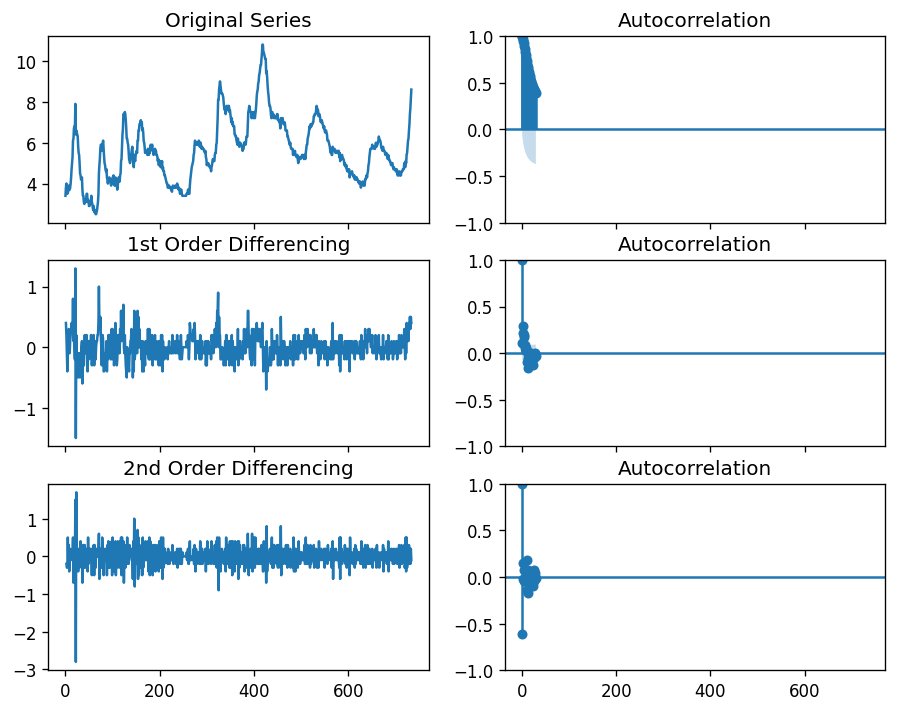

In [4]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
df = q1['Rate']
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

# plt.savefig('d.pdf')
plt.show()

图像感觉原始数据有点不平稳，但不敢特别确定，因此先检测序列的平稳性（ADF）

In [5]:
from statsmodels.tsa.stattools import adfuller
r = q1['Rate']
r_result = adfuller(r)
r_result

(-2.782820773972874,
 0.06076990891140676,
 12,
 722,
 {'1%': -3.439439614524914,
  '5%': -2.865551414233055,
  '10%': -2.5689061365397747},
 -297.05252289679424)

可以看出，p值为0.06的样子，在95%的置信水平上可以拒绝原假设所以数据不平稳，考虑做一阶差分。

In [6]:
rd = r.diff().dropna()
rd_result = adfuller(rd)
rd_result

(-7.953467602320841,
 3.0814846610671905e-12,
 11,
 722,
 {'1%': -3.439439614524914,
  '5%': -2.865551414233055,
  '10%': -2.5689061365397747},
 -324.594084937499)

p值非常小了，可以认为一阶差分足够，该差分序列平稳。
为了准确，考虑用acf和pacf进行模型初步阶数确定，再用AICc进行具体阶数的确定。

C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


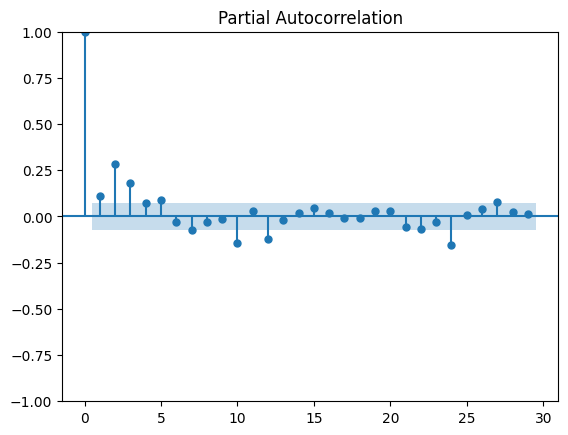

In [7]:
mpl.rcParams.update(mpl.rcParamsDefault)
plot_pacf(rd)
# plt.savefig('p.pdf')
plt.show()

看出AR的阶数选12及以内（太大的效果不一定好）（感觉5以内就行）

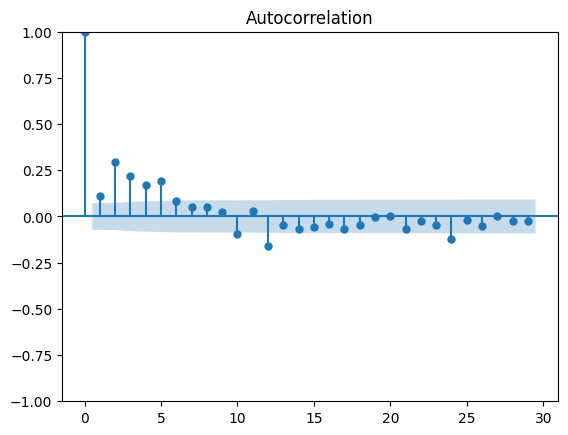

In [8]:
plot_acf(rd)
# plt.savefig('a.pdf')
plt.show()

看出MA的阶数选12及以内（也感觉5以内就行）

In [9]:
import statsmodels.tsa.stattools as st

model = st.arma_order_select_ic(rd, max_ar=5, max_ma=5, ic=['aicc', 'bic', 'hqic'])

model.aicc_min_order #返回一个元组，分别为p值和q值

C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

(5, 3)

用AICc准则算出来是（5，3）

In [10]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(r, order=(5,1,3))
result = model.fit()
result.summary()

C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                  735
Model:                 ARIMA(5, 1, 3)   Log Likelihood                 155.700
Date:                Sun, 01 May 2022   AIC                           -293.399
Time:                        21:33:02   BIC                           -252.012
Sample:                             0   HQIC                          -277.436
                                - 735                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7323      0.041     17.654      0.000       0.651       0.814
ar.L2          0.9005      0.061     14.832      0.000       0.781       1.019
ar.L3         -0.9600      0.055    -17.352      0.000      -1.068      -0.852
ar.L4         -0.1400      0.037     -3.799      0.000      -0.212      -0.068
ar.L5          0.2086      0.043      4.876      0.000       0.125       0.292
ma.L1         -0.7410      0.034    -22.048      0.000      -0.807      -0.675
ma.L2         -0.6815      0.052    -13.054      0.000      -0.784      -0.579
ma.L3          0.9298      0.032     29.442      0.000       0.868       0.992
sigma2         0.0382      0.001     27.771      0.000       0.036       0.041
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              1250.55
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

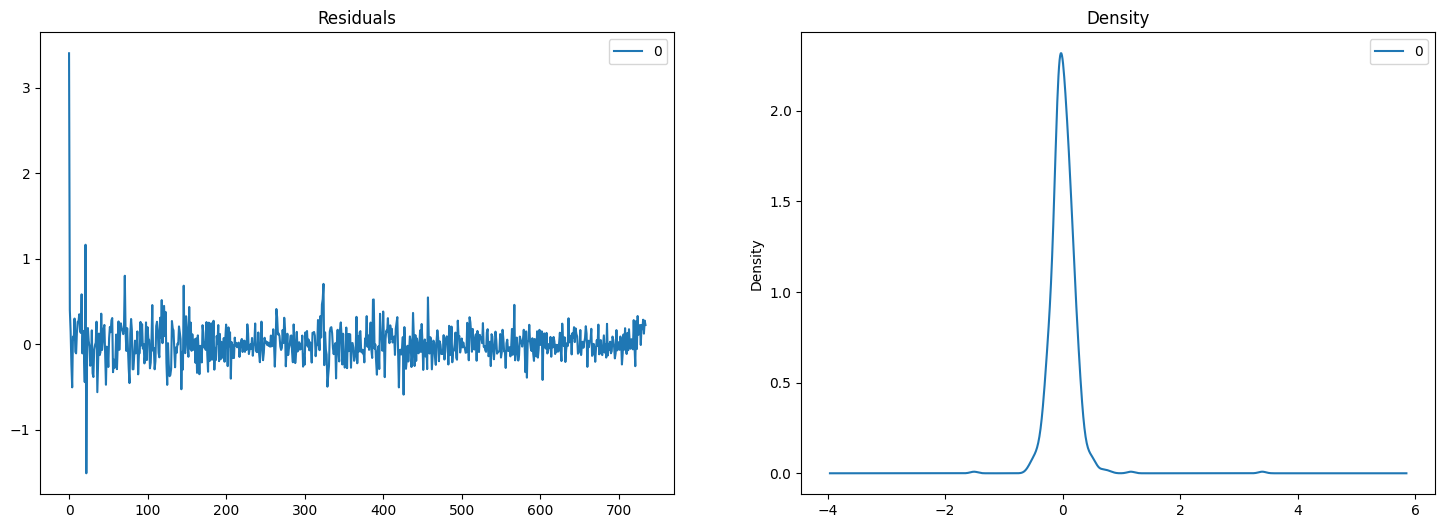

In [12]:
plt.rcParams.update({'figure.figsize':(18,6), 'figure.dpi':100})
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.savefig('res.pdf')
plt.show()

看出模型残差的分布基本是正态

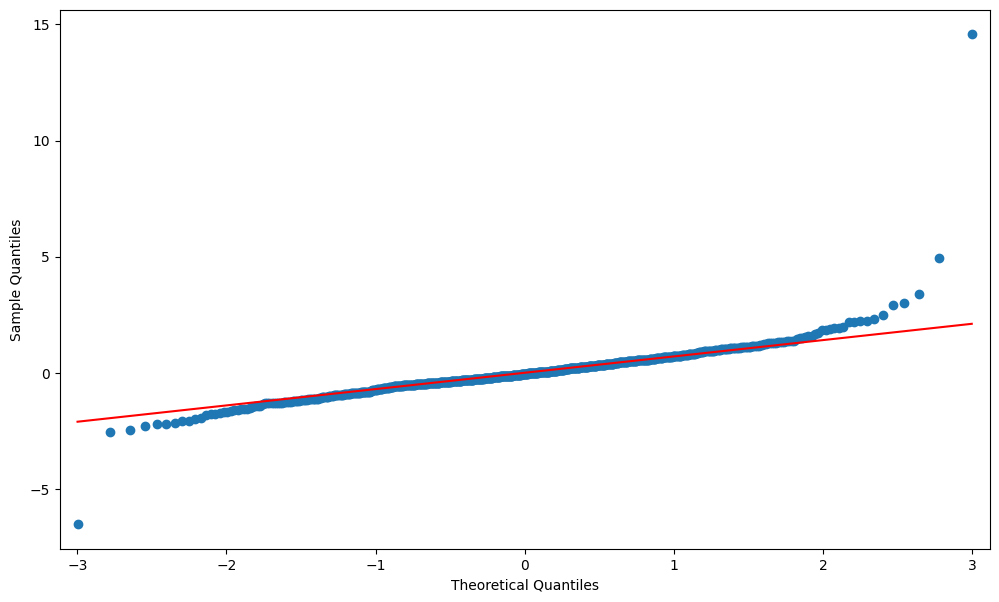

In [13]:
mpl.rcParams.update(mpl.rcParamsDefault)
resid = result.resid
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':100})
from statsmodels.graphics.api import qqplot

qqplot(resid, line='q', fit=True)
# plt.savefig('qq.pdf')
plt.show()

用QQ图检验，基本在一条直线上，可以认为残差分布符合正态，模型拟合良好。

In [14]:
pred = result.predict(start=1, end =len(r) + 4 )
print(pred[-4:])

736    9.007309
737    9.158328
738    9.296065
739    9.396350
Name: predicted_mean, dtype: float64


即，预测4，5，6，7月的失业率为：9.007309，9.158328，9.296065，9.396350

In [25]:
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
import seaborn
import scipy.signal as signal


def fftTransfer(timeseries, n=10, fmin=0.2):
    yf = abs(fft(timeseries))  # 取绝对值
    yfnormlize = yf / len(timeseries)  # 归一化处理
    yfhalf = yfnormlize[range(int(len(timeseries) / 2))]  # 由于对称性，只取一半区间
    yfhalf = yfhalf * 2   # y 归一化

    xf = np.arange(len(timeseries))  # 频率
    xhalf = xf[range(int(len(timeseries) / 2))]  # 取一半区间


    plt.subplot(211)
    x = np.arange(len(timeseries))  # x轴
    plt.plot(x, timeseries)
    plt.title('Original wave')

    plt.subplot(212)
    plt.plot(xhalf, yfhalf, 'r')
    plt.title('FFT of Mixed wave(half side frequency range)', fontsize=10, color='#7A378B')  # 注意这里的颜色可以查询颜色代码表

    fwbest = yfhalf[signal.argrelextrema(yfhalf, np.greater)]
    xwbest = signal.argrelextrema(yfhalf, np.greater)
    plt.plot(xwbest[0][:n], fwbest[:n], 'o', c='yellow')
    plt.show(block=False)
    plt.show()

    xorder = np.argsort(-fwbest)  # 对获取到的极值进行降序排序，也就是频率越接近，越排前
    print('xorder = ', xorder)
    print(type(xorder))
    xworder = list()
    xworder.append(xwbest[x] for x in xorder)  # 返回频率从大到小的极值顺序
    fworder = list()
    fworder.append(fwbest[x] for x in xorder)  # 返回幅度

    if len(fwbest) <= n:
        fwbest = fwbest[fwbest >= fmin].copy()
        return len(timeseries)/xwbest[0][:len(fwbest)], fwbest    #转化为周期输出
    else:
        fwbest = fwbest[fwbest >= fmin].copy()
        print(len(fwbest))
        print(xwbest)
        return len(timeseries)/xwbest[0][:len(fwbest)], fwbest  # 只返回前n个数   #转化为周期输出


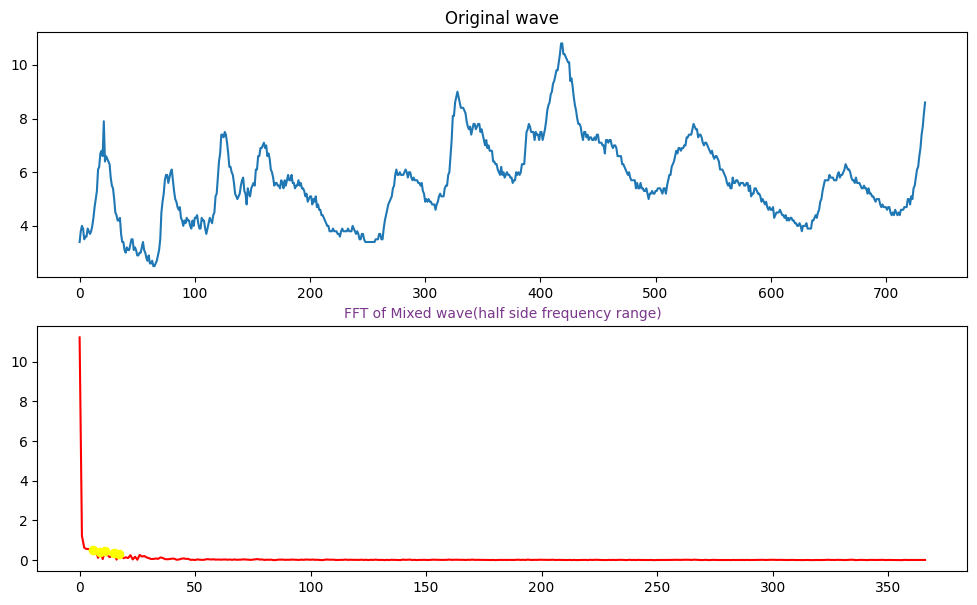

xorder =  [  0   2   1   3   4   8   6   9   7   5  11  13  10  12  14  24  17  18
  23  16  25  22  20  33  21  19  36  34  55  39  31  49  68  29  50  59
  32  44  28  37  93  27  54  26  41  15  47 103 116  66 113  71  70  30
  35  56  83  92  79 105  78  40  42  94  43  58  67 127  57  60  82 114
  91  51 106  69  53  90 124  85 120  38  45  46  95  63 117  72  52  74
  80 119  48  65  84 107  77 126  61 118 101  76  64 109 115 104  81  75
  89  98 100  62 111 122 102 121  96  87  73  99 108  86 125 112  88  97
 110 123]
<class 'numpy.ndarray'>
84
(array([  6,   9,  11,  15,  17,  20,  22,  24,  26,  28,  33,  35,  40,
        45,  47,  49,  51,  55,  58,  60,  63,  65,  67,  71,  77,  79,
        81,  83,  86,  88,  90,  92,  96,  98, 101, 103, 107, 109, 113,
       115, 117, 122, 124, 126, 128, 131, 133, 135, 137, 140, 143, 145,
       147, 149, 153, 160, 164, 166, 168, 170, 172, 176, 179, 182, 184,
       186, 190, 192, 194, 197, 199, 205, 207, 210, 212, 214, 217, 219,
       22

In [29]:
x , y=fftTransfer(np.array(r),n=5,fmin = 0.015)                     #快速傅里叶变换
print('x = ',x) #周期

由傅立叶变换看出来，增幅最大的前五个点为[122.5, 81.66666667, 66.81818182, 49, 43.23529412], 这就是失业率的周期可以的取值（单位是月）

# 2.4

In [31]:
q2 = pd.read_csv(r'./data/m-deciles08.txt', sep='\s+')

In [32]:
q2

,date,CAP1RET,CAP2RET,CAP9RET,CAP10RET
0,19700130,0.054383,-0.004338,-0.073082,-0.076874
1,19700227,0.020264,0.020155,0.064185,0.059512
2,19700331,-0.031790,-0.028090,-0.004034,-0.001327
3,19700430,-0.184775,-0.193004,-0.115825,-0.091112
4,19700529,-0.088189,-0.085342,-0.085565,-0.053193
...,...,...,...,...,...
463,20080829,-0.000183,-0.012646,0.017067,0.005598
464,20080930,-0.112060,-0.132327,-0.121940,-0.086404
465,20081031,-0.126414,-0.129844,-0.226203,-0.177655
466,20081128,-0.149964,-0.114484,-0.098652,-0.071501


## 2.4(a)

In [37]:
d2 = q2['CAP2RET']
d10 = q2['CAP10RET']

In [38]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
print(lb_test(d2,lags=12,boxpierce=False))
print(lb_test(d10,lags=12,boxpierce=False))

      lb_stat     lb_pvalue
1   19.542652  9.837839e-06
2   20.000317  4.539275e-05
3   21.801624  7.173376e-05
4   22.505769  1.589178e-04
5   23.445496  2.773908e-04
6   23.519392  6.399395e-04
7   23.673791  1.299903e-03
8   27.278105  6.328968e-04
9   28.496943  7.875091e-04
10  29.461668  1.048607e-03
11  30.008670  1.579635e-03
12  55.736333  1.335025e-07
      lb_stat  lb_pvalue
1    0.776041   0.378355
2    1.059610   0.588720
3    1.258127   0.739099
4    1.259323   0.868238
5    7.181368   0.207497
6    7.982898   0.239359
7    8.047965   0.328383
8    8.117636   0.422064
9    8.139662   0.520135
10   9.198599   0.513365
11   9.265774   0.597375
12  10.687154   0.555903


从acorr_ljungbox检验中可以看出：

对于Decile2序列，前十二个间隔的p值均非常小小于0.05，因此拒绝原假设，故存在自相关；

对于Decile10序列，前十二个间隔的p值均大于0.05，因此不能拒绝原假设，故可以认为前十二个间隔的自相关系数为0；

## 2.4(b)

由于题目已经要求建立arma模型，故，对原始数据的预处理和判断就不用考虑，直接进行定阶：

C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


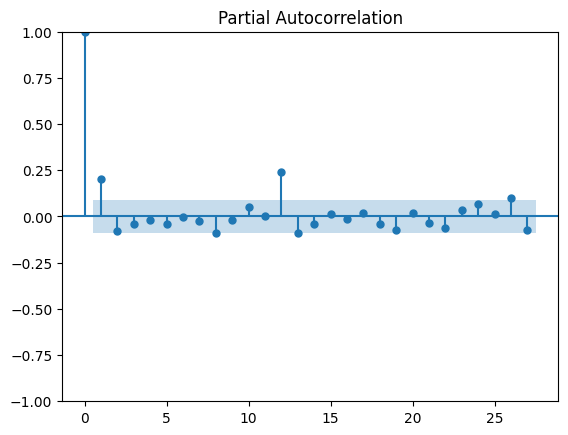

In [56]:
mpl.rcParams.update(mpl.rcParamsDefault)
plot_pacf(d2)
# plt.savefig('p.pdf')
plt.show()

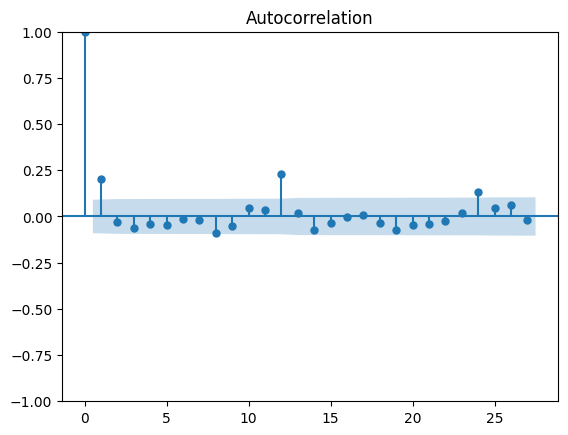

In [57]:
plot_acf(d2)
# plt.savefig('a.pdf')
plt.show()

In [59]:
model = st.arma_order_select_ic(d2, max_ar=12, max_ma=12, ic=['aicc', 'bic', 'hqic']) # 都选12是因为上面的acf和pacf都是在第12阶明显显著
model.aicc_min_order #返回一个元组，分别为p值和q值

C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

(2, 12)

看到，经过信息定阶，最终选择ARMA（2，12）

In [60]:
model = ARIMA(d2, order=(2,0,12))
result = model.fit()
result.summary()

C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CAP2RET   No. Observations:                  468
Model:                ARIMA(2, 0, 12)   Log Likelihood                 645.492
Date:                Sun, 01 May 2022   AIC                          -1258.983
Time:                        23:28:07   BIC                          -1192.608
Sample:                             0   HQIC                         -1232.865
                                - 468                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0106      0.004      2.774      0.006       0.003       0.018
ar.L1          0.1133      0.144      0.785      0.432      -0.169       0.396
ar.L2         -0.4441      0.142     -3.119      0.002      -0.723      -0.165
ma.L1          0.1136      0.148      0.769      0.442      -0.176       0.403
ma.L2          0.4204      0.158      2.658      0.008       0.110       0.730
ma.L3          0.0269      0.060      0.444      0.657      -0.092       0.145
ma.L4          0.0224      0.057      0.394      0.694      -0.089       0.134
ma.L5         -0.1032      0.048     -2.145      0.032      -0.197      -0.009
ma.L6         -0.0146      0.047     -0.314      0.754      -0.106       0.077
ma.L7          0.0306      0.057      0.541      0.589      -0.080       0.142
ma.L8         -0.0901      0.057     -1.573      0.116      -0.202       0.022
ma.L9         -0.0213      0.056     -0.384      0.701      -0.130       0.088
ma.L10         0.0632      0.062      1.021      0.307      -0.058       0.185
ma.L11        -0.0665      0.050     -1.323      0.186      -0.165       0.032
ma.L12         0.2866      0.041      6.975      0.000       0.206       0.367
sigma2         0.0037      0.000     20.933      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               558.21
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

从p值看到，模型拟合的不是很好，可能由于原始数据的平稳性不太行。

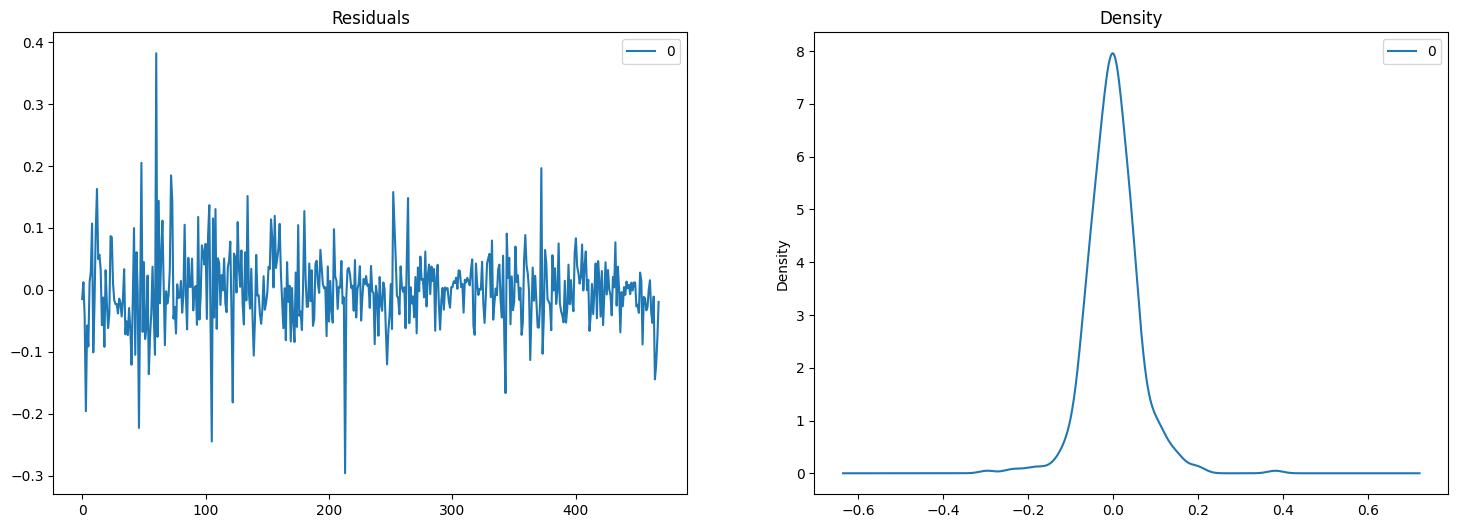

In [61]:
plt.rcParams.update({'figure.figsize':(18,6), 'figure.dpi':100})
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.savefig('res.pdf')
plt.show()

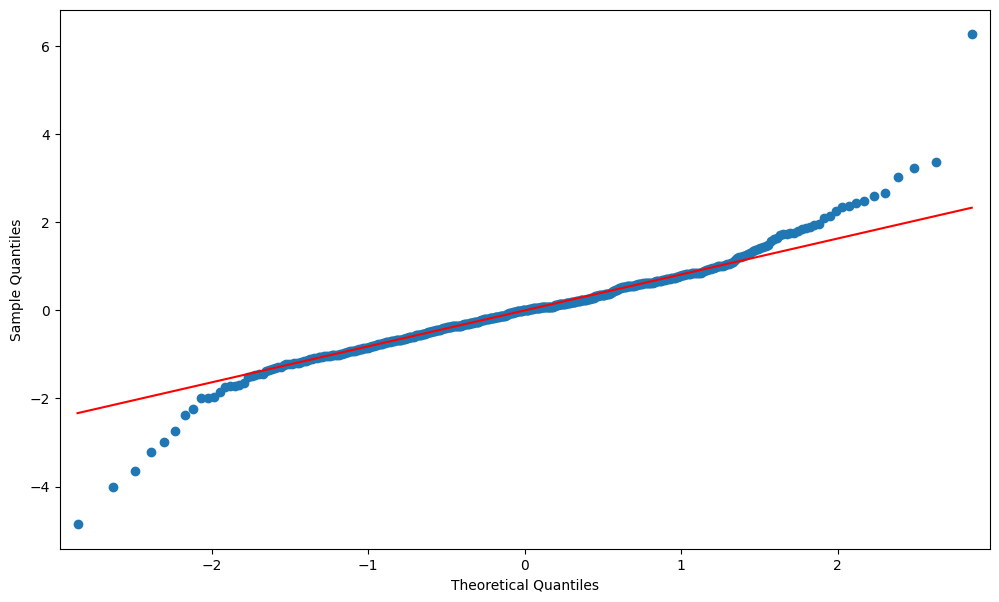

In [62]:
mpl.rcParams.update(mpl.rcParamsDefault)
resid = result.resid
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':100})
from statsmodels.graphics.api import qqplot

qqplot(resid, line='q', fit=True)
# plt.savefig('qq.pdf')
plt.show()

In [63]:
from scipy import stats 
stats.normaltest(resid)

NormaltestResult(statistic=68.3389335833509, pvalue=1.44673544831942e-15)

依旧通过残差分布图，QQ图发现拟合效果还不错，再通过对残差直接进行正态性检验，由上式结果p值非常小，拒绝原假设，故残差确实服从均值为0的正态分布。

$$
\begin{equation}
\begin{aligned}
	Y_t = & 0.0106 + 0.1133Y_{t-1} - 0.4441Y_{t-2} + \epsilon + 0.1136\epsilon_{t-1} +0.4204\epsilon_{t-2} + 0.0269\epsilon_{t-3} + 0.0224\epsilon_{t-4} - 0.1032\epsilon_{t-5} \\
		& - 0.0146\epsilon_{t-6} + 0.0306\epsilon_{t-7} -0.0901\epsilon_{t-8} -0.0213\epsilon_{t-9} + 0.0632\epsilon_{t-10} -0.0665\epsilon_{t-11} + 0.2866\epsilon_{t-12}
\end{aligned}
\end{equation}
$$


## 2.4（c）

In [66]:
pred = result.predict(start=len(d2)+1, end =len(d2) + 12)
print(pred[len(d2)+1],pred[len(d2)+12])

0.021589685059027912 0.01664618307180645


In [104]:
sig = result.params.sigma2  

## 一步预测的标准误差
v1 = sig

## 多步预测编写函数
p = result.params
import sympy as sp
x = sp.symbols('x')
y = 1
for i in range(12):
    y = y - p[i+3]*x**(i+1)
y = y/(1-p[1]-p[2])
w = []
for i in range(12):
    c = 0
    y = sp.diff(y,x)
    c = float(y.evalf(subs={x:c}))
    w.append(c)
v12 = sig
for i in range(11):
    v12 = v12 + sig*w[i]

v1**0.5,v12**0.5

(0.0608047860393138, 82.2732953018807)

看到：一步预测0.021589685059027912，标准误差0.0608047860393138；
十二步预测0.01664618307180645，标准误差82.2732953018807

# 2.5

In [2]:
q3 = pd.read_csv(r'./data/d-ibm3dx7008.txt', sep='\s+')

In [3]:
q3

,Date,rtn,vwretd,ewretd,sprtrn
0,19700102,0.000686,0.012137,0.033450,0.010211
1,19700105,0.009596,0.006375,0.018947,0.004946
2,19700106,0.000679,-0.007233,-0.005776,-0.006848
3,19700107,0.000678,-0.001272,0.003559,-0.002047
4,19700108,0.002034,0.000564,0.002890,0.000540
...,...,...,...,...,...
9840,20081224,-0.000993,0.004463,0.005254,0.005781
9841,20081226,0.010060,0.007170,0.011629,0.005356
9842,20081229,-0.000984,-0.004481,-0.016514,-0.003873
9843,20081230,0.028308,0.024951,0.021692,0.024407


In [4]:
r = abs(q3['rtn'])

In [5]:
from statsmodels.tsa.stattools import acf
acf(r,nlags=100)

array([1.        , 0.19470559, 0.16377987, 0.14443422, 0.17668511,
       0.17229976, 0.14879778, 0.12996846, 0.13179308, 0.14904384,
       0.13106486, 0.13941002, 0.13721279, 0.1261541 , 0.12559933,
       0.14419394, 0.13312196, 0.14621057, 0.11462894, 0.12941782,
       0.13792132, 0.12312799, 0.11480014, 0.11341119, 0.11574024,
       0.11911807, 0.09816461, 0.12160989, 0.11092441, 0.1214557 ,
       0.134553  , 0.11214585, 0.11446333, 0.10377217, 0.11734547,
       0.12121045, 0.0984307 , 0.10173338, 0.1156344 , 0.10188767,
       0.09256838, 0.1021207 , 0.09829767, 0.09782616, 0.08081178,
       0.12191924, 0.09754091, 0.09377938, 0.09849074, 0.09193119,
       0.10891882, 0.10933508, 0.10086984, 0.09919402, 0.09545852,
       0.09990924, 0.11276762, 0.11814136, 0.10295986, 0.08797526,
       0.08518904, 0.10724155, 0.1489239 , 0.13391576, 0.10198326,
       0.09726721, 0.0853525 , 0.09945949, 0.09209789, 0.08814076,
       0.07743485, 0.08714156, 0.10179558, 0.09831475, 0.08080

前100个间隔的acf见上矩阵。

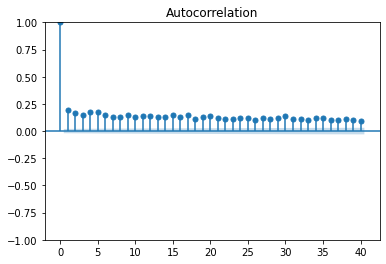

In [6]:
plot_acf(r)
plt.show()

从acf数据和图像可以看出，在滞后很多期之后的acf并没有明显趋于0相反还是很显著，有很多大于2sigma明显显著，故可以判断存在长范围相依。

# 2.6

为了方便读取，加入一行表头

In [6]:
# q4 = np.loadtxt("./data/power6.txt")
q4 = pd.read_csv(r'./data/power6.txt', sep='\s+')

In [7]:
q4

,log
0,9.2691
1,9.2465
2,9.2639
3,9.2784
4,9.3147
...,...
259,10.0499
260,10.0598
261,9.9722
262,9.9080


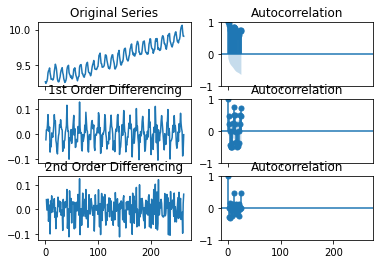

In [8]:
df = q4['log']
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

# plt.savefig('d.pdf')
plt.show()

从图像看出序列明显有周期和趋势，不是平稳序列

In [16]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
# data = df.copy(deep=True)
# #divide into train and validation set
# train = data[:int(0.7*(len(data)))]
# valid = data[int(0.7*(len(data))):]
model = pm.auto_arima(df, trace=True, error_action='ignore', suppress_warnings=True)
model = ARIMA(df, order=(2,1,2))
result = model.fit()
result.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1106.471, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-893.743, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-954.045, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-942.644, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-894.944, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-968.999, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-950.303, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1050.089, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1014.875, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-952.105, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-975.752, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1055.866, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1086.493, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-1141.637, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]    

C:\Users\20123\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    log   No. Observations:                  264
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 575.818
Date:                Mon, 02 May 2022   AIC                          -1141.637
Time:                        01:49:54   BIC                          -1123.776
Sample:                             0   HQIC                         -1134.459
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7302      0.003    496.402      0.000       1.723       1.737
ar.L2         -0.9990      0.002   -554.781      0.000      -1.003      -0.995
ma.L1         -1.7833      0.035    -51.231      0.000      -1.852      -1.715
ma.L2          0.9787      0.037     26.169      0.000       0.905       1.052
sigma2         0.0007   7.05e-05      9.963      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  12.26   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.00   Prob(JB):                         0.70
Heteroskedasticity (H):               1.22   Skew:                            -0.00
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

如上，利用自动arima函数使用AIC准则计算得到ARIMA（2，1，2）

In [17]:
pred = result.predict(start=len(df)+1, end =len(df) + 24)
pred

265     9.873489
266     9.890503
267     9.925601
268     9.969331
269    10.009929
270    10.036485
271    10.041873
272    10.024667
273     9.989513
274     9.945878
275     9.905502
276     9.879234
277     9.874123
278     9.891520
279     9.926729
280     9.970266
281    10.010420
282    10.036400
283    10.041236
284    10.023649
285     9.988388
286     9.944950
287     9.905019
288     9.879326
Name: predicted_mean, dtype: float64

end